In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import gudhi

from functions.data_filtering import ICAO_codes, large_gap_filter
from functions.data_processing import flight_pers, sublevelset_persistence
from functions.data_loading import linkage_cluster_persistances, flights_from_query

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from traffic.core import Traffic, Flight
from gudhi.representations import Landscape

Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\04c4abc67243f7be7999638172e10eb5.parquet created on 1732715054.805771
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\0f35da0a5902da0bef9b2fd192125d89.parquet created on 1732714737.6834626
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\157697e5d02417a592bb787a159e36f8.parquet created on 1732714607.3741887
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\19ab13f1e01dd080630a70a0f237b8c1.parquet created on 1732714576.4025197
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\398f9ee9ddc4c92ced03ded994db41e8.parquet created on 1732715371.0696118
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\4eb476df534f55bc8c63bc8768774992.parquet created on 1732715133.2720706
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\4f3bd34b3e9bfc5cd7d36cd6124a9d6a.parquet created on 1732714670.7318988
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\659db29ff0208d81ef15ea6d

In [2]:
# The flights can be converted into a Traffic object
count = 500
with_GA_flights = flights_from_query(None, count, "data/with_GA_flights.pkl")
without_GA_flights = flights_from_query(None, count, "data/without_GA_flights.pkl")

In [3]:
with_GA_flights = list(filter(large_gap_filter, with_GA_flights))
without_GA_flights = list(filter(large_gap_filter, without_GA_flights))

with_GA_labels = np.ones(len(with_GA_flights))
without_GA_labels = np.zeros(len(without_GA_flights))

flights = with_GA_flights + without_GA_flights
labels = np.concatenate((with_GA_labels, without_GA_labels))

persistence, paths = flight_pers(flights)
sub_persistence, sub_paths = sublevelset_persistence(flights)

100%|██████████| 3188/3188 [00:36<00:00, 87.92it/s] 


In [4]:
from tqdm import tqdm
baseline = []


for dataset in [with_GA_flights, without_GA_flights]:
    for flight in tqdm(dataset, total=len(dataset)):
        data = flight.data.copy(deep=True)
        
        unwrapped = np.unwrap(np.deg2rad(data["track"]), period=2 * np.pi, discont=np.pi)
        max_unwrapped = unwrapped.max()
        min_unwrapped = unwrapped.min()
        diff_unwrapped = max_unwrapped - min_unwrapped
        
        max_velocity = data["groundspeed"].max()
        min_velocity = data["groundspeed"].min()
        mean_velocity = data["groundspeed"].mean()
        max_heading = data["vertical_rate"].max()
        min_heading = data["vertical_rate"].min()
        mean_heading = data["vertical_rate"].mean()
        longitude_diff = data["longitude"].max() - data["longitude"].min()
        latitude_diff = data["latitude"].max() - data["latitude"].min()
        
        baseline.append([max_unwrapped, min_unwrapped, diff_unwrapped, max_velocity, min_velocity, mean_velocity, max_heading, min_heading, mean_heading, longitude_diff, latitude_diff])

100%|██████████| 1592/1592 [00:00<00:00, 2574.54it/s]


In [5]:
resolution = 10
n_landscapes = 3
landscape = Landscape(resolution=resolution, num_landscapes=n_landscapes)
landscapes = []
sub_landscapes = []

baseline = np.array(baseline)
for i in persistence:
    landscapes.append(landscape.fit_transform([i]))
for i in sub_persistence:
    sub_landscapes.append(landscape.fit_transform([i]))
    
landscapes = np.array(landscapes)
landscapes = landscapes.reshape(landscapes.shape[0], landscapes.shape[2])
sub_landscapes = np.array(sub_landscapes)
sub_landscapes = sub_landscapes.reshape(sub_landscapes.shape[0], sub_landscapes.shape[2])

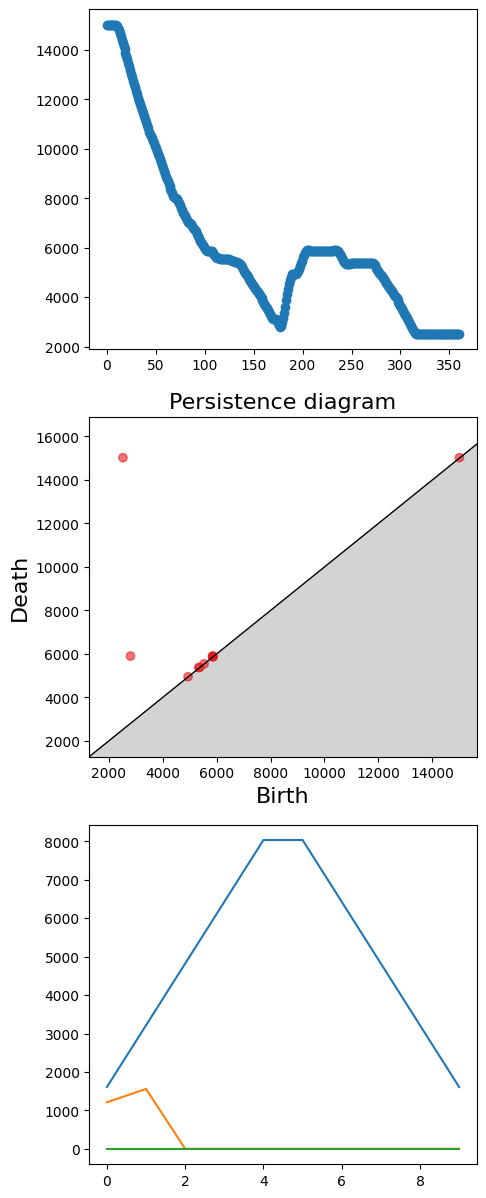

In [151]:
diagram = 2
fig, axs = plt.subplots(3, 1, figsize=(5, 15))

sub = True

if sub:
    path = sub_paths[diagram]
    pers = sub_persistence[diagram]
    landscape = sub_landscapes[diagram]
else: 
    path = paths[diagram]
    pers = persistence[diagram]
    landscape = landscapes[diagram]

axs[0].scatter(path[:, 0], path[:, 1])
gudhi.persistence_graphical_tools.plot_persistence_diagram(pers, axes=axs[1])

for i in range(n_landscapes):
    axs[2].plot(landscape[i*resolution:(i+1)*resolution])

In [302]:
datasets = []
datasets.append(baseline)
#datasets.append(landscapes)
#datasets.append(sub_landscapes)

X = np.concatenate(datasets, axis= 1)

mask = ~np.any(np.isnan(X), axis=1)
X = X[mask]
Y = labels[mask]

indices = np.arange(len(X))
seed = 4

x_train, x_test_val, y_train, y_test_val, indices_train, indices_test_val = train_test_split(X, Y, indices, test_size=0.3, random_state=seed)
x_test, x_val, y_test, y_val, indices_test, indices_val = train_test_split(x_test_val, y_test_val, indices_test_val, test_size=0.5, random_state=seed)

In [303]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree
from sklearn import svm

models = {
    "Decition Tree" : [tree.DecisionTreeClassifier(random_state=seed), {
        "min_samples_leaf" : [2, 3],
        "min_samples_split" : [2, 3]
    }],
    "Support Vector Machines" : [svm.SVC(random_state=seed), {
        "C" : [1, 2, 3], 
        "break_ties": [True, False], 
        "probability": [True, False]
    }],
    "Base line" : [DummyClassifier(strategy = "most_frequent"), {
        
    }],
    "Multi-layer Perception" : [MLPClassifier(random_state=seed, max_iter = 5000), {
        "hidden_layer_sizes" : [10, 20, 30], 
        
    }],
    "K Nearest Neighbors" : [KNeighborsClassifier(), {
        "n_neighbors" : [5, 10, 20, 40], 
        "p": [1, 2, 3]
    }],
    "Random Forrest Regressor" : [RandomForestClassifier(random_state=seed), {
        "max_depth": [3, 6], 
        "n_estimators" : [50, 100, 300]
    }],
    "Decision Tree Regressor" : [DecisionTreeClassifier(random_state=seed), {
        "min_samples_split" : [2, 3, 4],
        "min_samples_leaf" : [1, 2, 3]
    }],
}

In [304]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV

datalist = []

for i in models.keys():
    #does the gridsearch on the models
    model = GridSearchCV(models[i][0], models[i][1])
    #makes a prediction
    prediction = model.fit(x_train, y_train).predict(x_test)
    #finds out how good that prediction is
    
    balanced_accuracy = balanced_accuracy_score(y_test, prediction)
    datalist.append([model.best_estimator_, balanced_accuracy])

In [305]:
for i, j in datalist:
    print(f"{i.__repr__(): <70}: {j: .3}")

DecisionTreeClassifier(min_samples_leaf=3, random_state=4)            :  0.994
SVC(C=1, break_ties=True, probability=True, random_state=4)           :  0.99
DummyClassifier(strategy='most_frequent')                             :  0.5
MLPClassifier(hidden_layer_sizes=30, max_iter=5000, random_state=4)   :  0.985
KNeighborsClassifier(n_neighbors=20, p=1)                             :  0.99
RandomForestClassifier(max_depth=6, n_estimators=300, random_state=4) :  0.996
DecisionTreeClassifier(min_samples_leaf=3, random_state=4)            :  0.994


In [306]:
new_x_train =  np.concatenate((x_train, x_test), axis=0)
new_y_train = np.concatenate((y_train, y_test), axis=0)
best_model = sorted(datalist, key=lambda x: x[1], reverse=True)[0][0]

prediction = best_model.fit(new_x_train, new_y_train).predict(x_val)
balanced_accuracy = balanced_accuracy_score(y_val, prediction)
balanced_accuracy

0.9935897435897436

In [307]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, prediction)

array([[243,   0],
       [  3, 231]], dtype=int64)

Where the columns is prediction and the rows are the true value.
i will note that the dataset is not 100% accurate. there are false positives:



The GA detection algorithm sometimes fails to detect GAs either:
* if GAs are initialized early on the approach and have no or only a short climb phase, 
* if GAs have a very tight turn radius and only a short leg on the final approach (as usually performed by small general aviation aircraft), or 
* if GAs directly divert to other airports.

### adding sublevel set height:
this doesnt seem to improve the results, and mostly just confuses the models :/


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

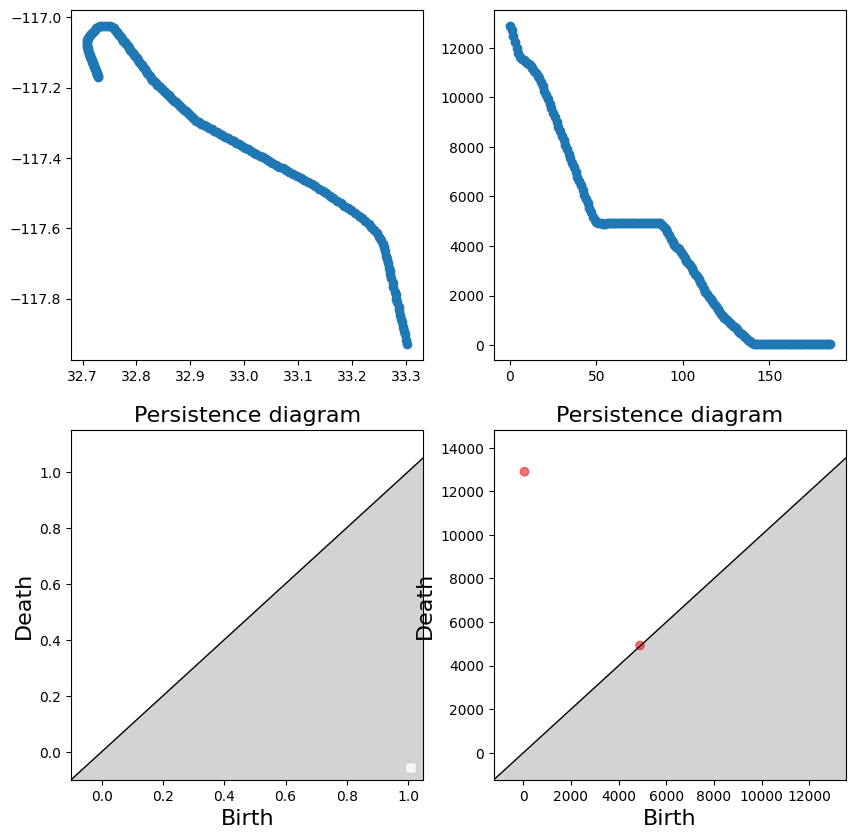

In [315]:
false_positives = np.where(np.logical_and(y_val == 1, prediction == 0))[0]
false_negatives = np.where(np.logical_and(y_val == 0, prediction == 1))[0]

index = 0
#index = indices_val[false_negatives[index]]
index = 2433

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
path = paths[index]
axs[0, 0].scatter(path[:, 0], path[:, 1])

path = sub_paths[index]
axs[0, 1].scatter(path[:, 0], path[:, 1])

gudhi.persistence_graphical_tools.plot_persistence_diagram(sub_persistence[index], axes=axs[1, 1])
gudhi.persistence_graphical_tools.plot_persistence_diagram(persistence[index], axes=axs[1, 0])

In [309]:
print(f"{indices_val[false_positives]} {indices_val[false_negatives]}")

[ 875 1249  712] []


In [279]:
[ 875 1249  712] []
[ 875 1249  712] [2771 2376]
[1249  712] [2433]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (37640811.py, line 1)

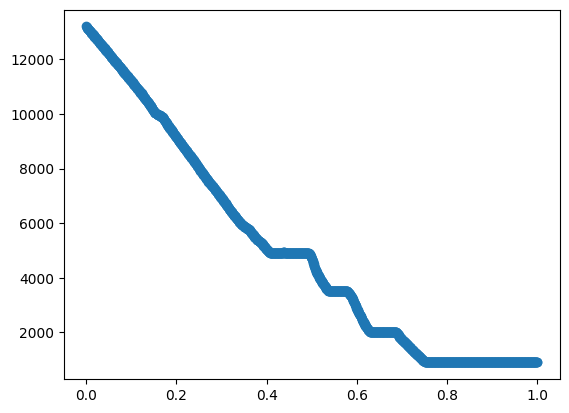

In [184]:
index = 2771
path = flights[index].data[["altitude"]].to_numpy()

x_values = [x / len(path) for x in range(len(path))]
plt.scatter(x_values, path)